# Mental Health in Tech
Используя данные опросов Open Source Mental Illness (OSMI) за период с 2014 по 2019 год, исследование будет направлено на изучение особенностей психического здоровья в сфере технологий. Анализируя отношение к психическому здоровью и частоту нарушений психического состояния на рабочем месте, можно выявить тенденции и изменения в течение этих лет.
- Ссылка на датасет: [Mental Health in Tech](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry)

#### Импорт нужных библиотек и подключение к БД

In [103]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

In [83]:
# Подключение к бд в которой будут храниться данные после обработки
con_final = sqlite3.connect('final_dataset', timeout=10)

# Подключение к бд в которой хранятся оригинальные данные
con_original = sqlite3.connect('data\mental_health.sqlite', timeout=10)

# Создание курсора для выполнения SQL-запросов
cur_final = con_final.cursor()
cur_original = con_original.cursor()

# Загружаем данные из файла mental_health.sqlite
answers_df = pd.read_sql_query("SELECT * from answer", con_original)
questions_df = pd.read_sql_query("SELECT * from question", con_original)
survey_df = pd.read_sql_query("SELECT * from survey", con_original)

#### Функции для предобработки
Этот блок функций для подготовке данных для последующего анализа.

##### <hide> Проверка на дубликаты и их удаление

In [84]:
def remove_dupcates(df):
    """
    Функция для поиска, вывода и удаления дубликатов в DataFrame.

    Параметры:
    - df (pandas.DataFrame): Исходный DataFrame.

    Возвращаемое значение:
    pandas.DataFrame: DataFrame без дубликатов.
    """
    # Подсчет количества дубликатов
    duplicates_count = df.duplicated().sum()

    # Получение названия датасета
    dataset_name = getattr(df, "name", "")

    # Вывод информации
    if duplicates_count > 0:
        print(f"Внимание: Обнаружено {duplicates_count} дубликат(а/ов) в датасете")
        # Удаление дубликатов и сохранение резервной копии
        df_no_duplicates = df.drop_duplicates()
        print(f"Дубликаты удалены. Размер DataFrame после удаления: {df_no_duplicates.shape}")
        return df_no_duplicates
    else:
        print("Дубликатов не найдено в датасете")
        return df

##### <hide> Работа с пропусками

In [85]:
def check_missing_values(df, missing_values=['-1', pd.NA, pd.NaT, None]):
    """
    Функция для выявления пропущенных значений в DataFrame.

    Параметры:
    - df (pandas.DataFrame): Исходный DataFrame.
    - missing_values (list): Список значений, обозначающих пропущенные значения 
      (по умолчанию [-1, pd.NA, pd.NaT, None]).

    Возвращаемое значение:
    None - функция выводит информацию о пропущенных значениях на экран.
    """
    # Подсчет пропущенных значений в каждом столбце
    missing_values_count = df.isin(missing_values).sum()

    # Вывод информации
    if missing_values_count.sum() > 0:
        print("Обнаружены пропущенные значения в следующих столбцах:")
        for column, count in missing_values_count.items():
            if count > 0:
                missing_vals = df[df[column].isin(missing_values)][column].unique()
                print(f"{column}: {count} пропущенных значений - {missing_vals}")
    else:
        print("Пропущенных значений не найдено.")

##### <hide> Стандартизация гендеров и названий стран

In [86]:
def standardise_gender(gender):
    """
    Приводит наименование гендера к стандартизированному виду.

    Параметры:
    - gender(str): Наименование гендера.

    Возвращаемое значение:
    Стандартизированное наименование гендера: 'female', 'male' или 'other'. 
    """
    if "female" in gender.lower() or "she" in gender.lower() or "femina" in gender.lower() or "woman" in gender.lower():
        return 'female'
    elif "male" in gender.lower() or "guy" in gender.lower() or "swm" in gender.lower() or "masculino" in gender.lower():
        return 'male'
    else: return 'other'

def standardise_country(answer):
    """
    Функция для стандартизации названий стран.

    Параметры:
    - answer (str): Название страны.

    Возвращаемое значение:
    Стандартизированное название страны. Если входная строка содержит 'United States of America'
    или 'United States', функция возвращает 'USA', в противном случае возвращает исходное значение.
    """
    if 'United States of America' in answer or 'United States' in answer:
        return 'USA' 
    return answer

#### <hide> Предобработка данных

In [87]:
# Приводим название столбцов к единому формату
questions_df.columns = ['question_text', 'question_id']
survey_df.columns = ['survey_id', 'description']
answers_df.columns = ['answer_text','survey_id', 'user_id', 'question_id']

In [88]:
# Поиск и удаление дубликатов
answers_df = remove_dupcates(answers_df)
survey_df = remove_dupcates(survey_df)
questions_df = remove_dupcates(questions_df)

Дубликатов не найдено в датасете
Дубликатов не найдено в датасете
Дубликатов не найдено в датасете


In [89]:
# Проверяем на пропущенные значения
check_missing_values(answers_df)
check_missing_values(survey_df)
check_missing_values(questions_df)

Обнаружены пропущенные значения в следующих столбцах:
answer_text: 56598 пропущенных значений - ['-1']
Пропущенных значений не найдено.
Пропущенных значений не найдено.


В датасете отсутствуют пропущенные значения, а те, которые могли возникнуть, уже были заменены на '-1'.

In [90]:
# Cтандатизируем гендеры
new_gender = answers_df[answers_df['question_id'] == 2]['answer_text'].map(standardise_gender)
answers_df.loc[answers_df.question_id == 2, 'answer_text'] = new_gender

# Cтандатизируем название стран
new_contry = answers_df[answers_df['question_id'] == 3]['answer_text'].map(standardise_country)
answers_df.loc[answers_df.question_id == 3, 'answer_text'] = new_contry

# Проверка результата
print(answers_df[answers_df['question_id'] == 2]['answer_text'].unique())
print(answers_df[answers_df['question_id'] == 3]['answer_text'].unique())

['female' 'male' 'other']
['USA' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Bahamas, The' 'Greece' 'Moldova'
 'Georgia' 'China' 'Czech Republic' 'Philippines' 'Lithuania' 'Venezuela'
 'Argentina' 'Vietnam' 'Slovakia' 'Bangladesh' 'Algeria' 'Pakistan'
 'Afghanistan' 'Other' 'Brunei' 'Iran' 'Ecuador' 'Chile' 'Guatemala'
 'Taiwan' 'Serbia' 'Estonia' 'Iceland' 'Indonesia' 'Jordan' 'Ukraine'
 'Belarus' 'Turkey' '-1' 'Mauritius' 'Saudi Arabia' 'Kenya' 'Ethiopia'
 'Macedonia' 'Hong Kong' 'Ghana']


#### <hide> Загружаем предобработанные данные в final_dataset

In [91]:
questions_df.to_sql(con=con_final, name='question', index=False, if_exists='replace')
survey_df.to_sql(con=con_final, name='survey', index=False, if_exists='replace')
answers_df.to_sql(con=con_final, name='answer', index=False, if_exists='replace')

236898

Теперь есть возможность формулировать SQL-запросы как в СУБД, так и в Jupyter Notebook.<br> 
Приведенные ниже запросы были успешно выполнены и проверены в DBeaver.

#### Обзор данных

##### Общая информация

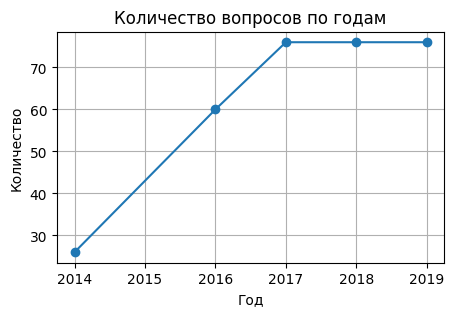

In [104]:
# Количество вопросов по годам
question_amount = '''
SELECT  a.survey_id,
		COUNT(DISTINCT(a.question_id)) AS question_amount
FROM answer a 
GROUP BY 1;
'''

cur_final.execute(question_amount)
rows = cur_final.fetchall()
question_amount = pd.DataFrame(rows, columns=('Год', 'Количество вопросов'))

plt.figure(figsize=(5, 3))
plt.plot(question_amount['Год'], question_amount['Количество вопросов'], marker='o')

# Настройка графика
plt.title('Количество вопросов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

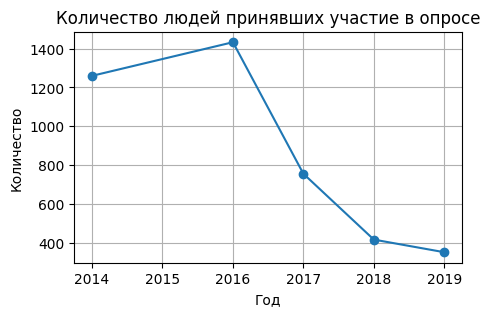

In [105]:
# Сколько людей прошло опрос в каждом году
people_amount = '''
SELECT  a.survey_id,
		COUNT(DISTINCT(a.user_id)) AS participants_amount
FROM answer a 
GROUP BY 1
'''

cur_final.execute(people_amount)
rows = cur_final.fetchall()
people_amount = pd.DataFrame(rows, columns=('Год', 'Количество людей'))

plt.figure(figsize=(5, 3))
plt.plot(people_amount['Год'], people_amount['Количество людей'], marker='o')

# Настройка графика
plt.title('Количество людей принявших участие в опросе')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

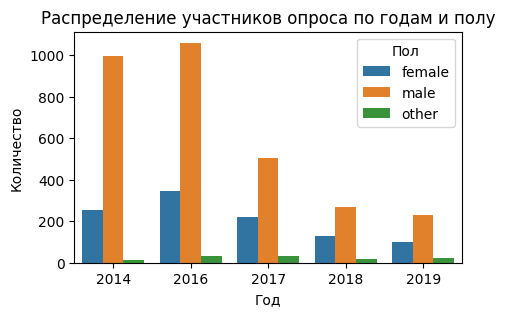

In [102]:

gender = '''
SELECT  survey_id, 
		answer_text,
		COUNT(DISTINCT(user_id)) AS amount
FROM answer
WHERE question_id = 2
GROUP BY survey_id, answer_text
ORDER BY survey_id, answer_text; 
'''

cur_final.execute(gender)
rows = cur_final.fetchall()
res = pd.DataFrame(rows, columns=('Год', 'Пол', 'Количество'))

plt.figure(figsize=(5, 3))
sns.barplot(x='Год', y='Количество', hue='Пол', data=res)
plt.title('Распределение участников опроса по годам и полу')
plt.show()


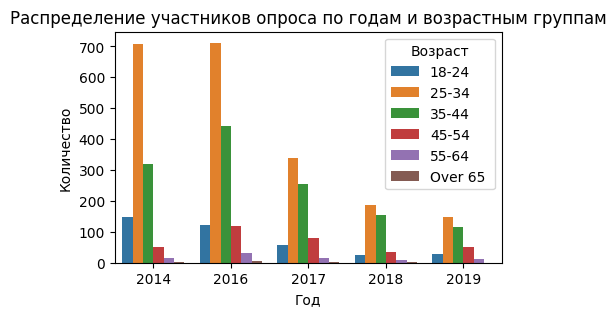

In [111]:
# Количество людей из разных возрстых групп по годам
ages = '''
SELECT a.survey_id, 
       CASE 
            WHEN a.answer_text BETWEEN 18 AND 24 THEN '18-24'
            WHEN a.answer_text BETWEEN 25 AND 34 THEN '25-34'
            WHEN a.answer_text BETWEEN 35 AND 44 THEN '35-44'
            WHEN a.answer_text BETWEEN 45 AND 54 THEN '45-54'
            WHEN a.answer_text BETWEEN 55 AND 64 THEN '55-64'
            WHEN a.answer_text BETWEEN 65 AND 99 THEN 'Over 65 '
        END AS age_group,  
    COUNT(a.user_id) AS count
FROM answer a 
WHERE a.question_id = 1 AND a.answer_text > 18   
GROUP BY a.survey_id, age_group
ORDER BY a.survey_id, age_group;  
'''

cur_final.execute(ages)
rows = cur_final.fetchall()
res = pd.DataFrame(rows, columns=('Год', 'Возраст', 'Количество'))

plt.figure(figsize=(5, 3))
sns.barplot(x='Год', y='Количество', hue='Возраст', data=res)
plt.title('Распределение участников опроса по годам и возрастным группам')
plt.show()

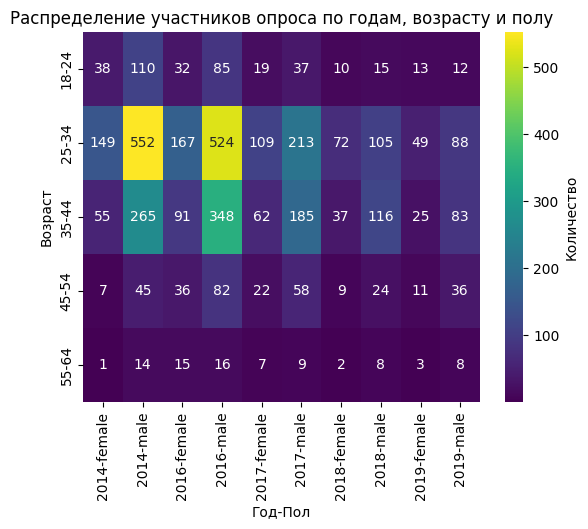

In [124]:
ages_gender = '''
WITH gender AS (
SELECT  a.user_id,
		a.answer_text
FROM answer a 
WHERE a.question_id = 2 AND a.answer_text != 'other'
),

age AS (
SELECT  a.survey_id,
		a.user_id,
        CASE 
            WHEN a.answer_text BETWEEN 18 AND 24 THEN '18-24'
            WHEN a.answer_text BETWEEN 25 AND 34 THEN '25-34'
            WHEN a.answer_text BETWEEN 35 AND 44 THEN '35-44'
            WHEN a.answer_text BETWEEN 45 AND 54 THEN '45-54'
            WHEN a.answer_text BETWEEN 55 AND 64 THEN '55-64'
        END AS age_group
FROM answer a 
WHERE a.question_id = 1 AND a.answer_text > 18 AND a.answer_text < 65
ORDER BY a.user_id 
)

SELECT  age.survey_id,
		age.age_group,
		gender.answer_text AS gender,
		COUNT(gender.answer_text) AS amount
FROM age
LEFT JOIN gender
ON age.user_id = gender.user_id
GROUP BY 1, 2, 3
ORDER BY 1, 2, 3;  
'''

cur_final.execute(ages_gender)
rows = cur_final.fetchall()
res = pd.DataFrame(rows, columns=('Год', 'Возраст', 'Пол', 'Количество'))

heatmap_data = res.pivot_table(index='Возраст', columns=['Год', 'Пол'], values='Количество')
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='g', cbar_kws={'label': 'Количество'})
plt.title('Распределение участников опроса по годам, возрасту и полу')
plt.show()

In [ ]:
genders = answers_df[answers_df['question_id'] == 2]
gender_distribution_1 = genders.groupby('survey_id')['answer_text'].value_counts().unstack()
gender_distribution_2 = genders.groupby(['survey_id', 'answer_text']).size().reset_index(name='Количество')

In [ ]:
sqlgender = '''
SELECT  a.survey_id, 
		a.answer_text,
		COUNT(DISTINCT(a.user_id)) AS amount
FROM answer a 
WHERE a.question_id = 2
GROUP BY a.survey_id, a.answer_text
ORDER BY a.survey_id, a.answer_text; 
'''

cur.execute(sqlgender)
rows = cur.fetchall()
pd.DataFrame(rows)

NameError: name 'cur' is not defined

In [ ]:
new_contry = copy_answer_df[copy_answer_df['question_id'] == 3]['answer_text'].map(contry_USA)
copy_answer_df.loc[copy_answer_df.question_id == 3, 'answer_text'] = new_contry

In [ ]:

copy_question_df.to_sql(con=con, name='question', index=False, if_exists='replace')
copy_survey_df.to_sql(con=con, name='survey', index=False, if_exists='replace')
copy_answer_df.to_sql(con=con, name='answer', index=False, if_exists='replace')

236898

In [ ]:
# Количество вопросов по годам
'''
SELECT  a.survey_id,
		COUNT(DISTINCT(a.question_id)) AS question_amount
FROM answer a 
GROUP BY 1
'''
# Сколько людей прошло опрос в каждом году
'''
SELECT  a.survey_id,
		COUNT(DISTINCT(a.user_id)) AS participants_amount
FROM answer a 
GROUP BY 1
'''

# Количество людей из разных возрстых групп по годам
'''
SELECT a.survey_id, 
       CASE 
            WHEN a.answer_text BETWEEN 18 AND 24 THEN '18-24'
            WHEN a.answer_text BETWEEN 25 AND 34 THEN '25-34'
            WHEN a.answer_text BETWEEN 35 AND 44 THEN '35-44'
            WHEN a.answer_text BETWEEN 45 AND 54 THEN '45-54'
            WHEN a.answer_text BETWEEN 55 AND 64 THEN '55-64'
            WHEN a.answer_text BETWEEN 65 AND 99 THEN 'Over 65 '
        END AS age_group,  
    COUNT(a.user_id) AS count
FROM answer a 
WHERE a.question_id = 1 AND a.answer_text > 18   
GROUP BY a.survey_id, age_group
ORDER BY a.survey_id, age_group;  
'''

# Сколько мужчин и женщин принимали участие в опросе в каждом году
'''
SELECT  a.survey_id, 
		a.answer_text,
		COUNT(DISTINCT(a.user_id)) AS amount
FROM answer a 
WHERE a.question_id = 2 AND (a.answer_text = 'female' OR a.answer_text = 'male')
GROUP BY a.survey_id, a.answer_text
ORDER BY a.survey_id, a.answer_text; 
'''

# Из каких стран 
'''
SELECT  a.answer_text,
		COUNT(DISTINCT(a.user_id)) AS amount
FROM answer a 
WHERE a.question_id = 3
GROUP BY a.answer_text
ORDER BY 2 DESC;  
'''

# Сколько людей имеют психические заболевания в год опроса
'''
SELECT 	a.survey_id,
		a.answer_text,
		COUNT(DISTINCT(a.user_id)) AS have_disorder
FROM answer a 
WHERE a.question_id = 33 AND a.answer_text = 'Yes'
GROUP BY 1
ORDER BY 1
'''

# Сколько процентов ответило что имеют псих заболевание 
'''
WITH aa AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 33
ORDER BY 1, 2
)

SELECT  aa.survey_id,
		COUNT(DISTINCT(aa.user_id)) AS amount_part,
		COUNT(IIF(aa.answer_text = 'Yes', 1, NULL)) AS have_disorder,
		(100 * COUNT(IIF(aa.answer_text = 'Yes', 1, NULL))) / COUNT(DISTINCT(aa.user_id)) AS percent_have_disorder
FROM aa
GROUP BY 1
'''

# Какие заболевания были тех кто ответил что имеют псих заболевание, какой процент от общего числа участников и от тех кто ответил что имеют псих заболевание 
'''
WITH aa115 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id,
		*
FROM answer a
WHERE a.question_id = 115
ORDER BY 3 DESC
),

aa33 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 33 AND a.answer_text = 'Yes' AND a.survey_id = 2016
ORDER BY 3 DESC
)

SELECT  aa115.answer_text,
		COUNT(DISTINCT(aa115.user_id)) AS amount_disorder,
		(100* COUNT(DISTINCT(aa115.user_id))) / total_amount AS percent_from_total,
		(100* COUNT(DISTINCT(aa115.user_id))) / total_amount_have_disorder AS percent_from_have_disorder
FROM 	aa115,
		(SELECT count(DISTINCT(aa115.user_id)) AS total_amount FROM aa115),
		(SELECT count(DISTINCT(aa33.user_id)) AS total_amount_have_disorder FROM aa33)
LEFT JOIN aa33
ON aa115.user_id = aa33.user_id
WHERE aa33.answer_text = 'Yes'
GROUP BY 1
ORDER BY 2 DESC 
'''

# Кем работают те кто ответил что имеют псих заболевание, какой процент от тех кто ответил что имеют псих заболевание 

'''
WITH aa117 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id,
		*
FROM answer a
WHERE a.question_id = 117
ORDER BY 3 DESC
),

aa33 AS (
SELECT 	a.survey_id,
		a.answer_text,
		a.user_id
FROM answer a
WHERE a.question_id = 33 AND a.answer_text = 'Yes' AND a.survey_id = 2016
ORDER BY 3 DESC
)

SELECT  aa117.answer_text,
		COUNT(DISTINCT(aa33.user_id)) AS amount_have_disorder,
		(100* COUNT(DISTINCT(aa33.user_id))) / total_amount_have_disorder AS percent_from_have_disorder
FROM 	aa117,
		(SELECT count(DISTINCT(aa33.user_id)) AS total_amount_have_disorder FROM aa33)
LEFT JOIN aa33
ON aa117.user_id = aa33.user_id
GROUP BY 1
ORDER BY 2 DESC 
'''

